In [3]:
!pip install --upgrade matplotlib > None # need refresh enviroment after installation

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [4]:
!pip install basemap > None

In [209]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats
from mpl_toolkits.basemap import Basemap

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.dummy import DummyRegressor

%matplotlib inline

# **1 Выбор и обоснование метрики для измерения качества**

Метрика: идентификация **коэффициентов** модели установки.




Выбранный набор данных состоит из 300 экспериментов и 25 параметров модели:
*   a1, a2 — коэффициенты матрицы состояния A;
*   b1, b2 — коэффициенты матрицы управления B;
*   u — входной сигнал
*   yi, i = [1, 20] — 20 значений выходного сигнала, снятых в процессе одного эксперимента.
---
Выбор обосновывается тем, что порой невозможно узнать, что происходит внутри рабочей установки, не разбирая ее корпус, но при этом этой установкой нужно как-то управлять. Как вариант можно сделать нейросеть, имитирующую поведение установки — генерирующую ее внутренние коэффициенты по известным входным и выходным сигналам (задача регрессии).


In [8]:
path = 'dataset_model.csv'
df = pd.read_csv(path, index_col='Unnamed: 0')

In [9]:
df.head()

,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,...,y_15,y_16,y_17,y_18,y_19,a1,a2,b1,b2,u
0,0.0,103.470474,169.841497,202.634886,217.431860,223.846126,226.572989,227.720839,228.201543,228.402313,...,228.545105,228.545542,228.545724,228.545800,228.545832,4.768043,4.528949,4.114231,4.197650,47.730118
1,0.0,47.284430,89.774170,113.979345,122.004075,120.914403,116.870131,113.302064,111.296707,110.649611,...,111.610162,111.580655,111.555527,111.541783,111.537599,2.332872,1.885917,2.314809,3.828850,31.755654
2,0.0,12.003113,22.219190,29.660820,34.898547,38.553882,41.099383,42.871039,44.103927,44.961858,...,46.701930,46.769713,46.816880,46.849702,46.872541,2.255614,3.962950,2.019615,2.178595,10.395001
3,0.0,5.945856,13.330533,19.974172,25.229365,29.101800,31.827782,33.685357,34.920257,35.725122,...,37.019445,37.047172,37.063602,37.073242,37.078841,1.005294,1.969880,1.180354,3.752236,6.134611
4,0.0,61.878596,110.339668,142.663314,163.015963,175.527032,183.136670,187.742940,190.525090,192.203788,...,194.631042,194.679661,194.708971,194.726642,194.737294,2.334700,3.389631,3.470272,1.687632,33.804580


# **2 Предварительный разведочный анализ набора данных**

## **Базовые характеристики/статистики для набора данных:**

In [10]:
df.columns # Список названий столбцов таблицы

Index(['y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9',
       'y_10', 'y_11', 'y_12', 'y_13', 'y_14', 'y_15', 'y_16', 'y_17', 'y_18',
       'y_19', 'a1', 'a2', 'b1', 'b2', 'u'],
      dtype='object')

In [11]:
df.shape # Размер таблицы

(300, 25)

In [12]:
df.dtypes # Типы данных

y_0     float64
y_1     float64
y_2     float64
y_3     float64
y_4     float64
y_5     float64
y_6     float64
y_7     float64
y_8     float64
y_9     float64
y_10    float64
y_11    float64
y_12    float64
y_13    float64
y_14    float64
y_15    float64
y_16    float64
y_17    float64
y_18    float64
y_19    float64
a1      float64
a2      float64
b1      float64
b2      float64
u       float64
dtype: object

In [13]:
df.isna().sum() # Кол-во пустых ячеек таблицы

y_0     0
y_1     0
y_2     0
y_3     0
y_4     0
y_5     0
y_6     0
y_7     0
y_8     0
y_9     0
y_10    0
y_11    0
y_12    0
y_13    0
y_14    0
y_15    0
y_16    0
y_17    0
y_18    0
y_19    0
a1      0
a2      0
b1      0
b2      0
u       0
dtype: int64

In [14]:
df.describe() # основная информация о содержимом таблицы

,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,...,y_15,y_16,y_17,y_18,y_19,a1,a2,b1,b2,u
count,300.0,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.0,40.880633,72.187323,89.880365,98.650525,103.328287,106.567309,109.236040,111.427730,113.126463,...,117.789003,118.136972,118.415445,118.638869,118.819732,2.955683,3.006971,2.968549,2.953105,24.435407
std,0.0,28.206495,50.358061,65.972703,77.579930,86.263850,92.613648,97.351834,101.101896,104.228646,...,114.888142,115.770601,116.506431,117.120719,117.634103,1.093079,1.150024,1.131990,1.145963,13.970145
min,0.0,2.007456,3.297535,3.779506,3.610293,3.426593,3.350384,3.349069,3.368544,3.381764,...,3.381632,3.381763,3.381806,3.381799,3.381783,1.005294,1.009634,1.006361,1.004126,1.656724
25%,0.0,16.289830,29.886041,37.038522,39.658376,38.441992,38.217613,38.805821,41.130345,41.738088,...,41.243465,41.244053,41.238625,41.235659,41.235860,2.094006,2.038736,2.023498,1.932997,12.229592
50%,0.0,35.359244,62.078134,74.554317,76.555502,78.575867,81.667287,84.868255,83.998880,84.940213,...,87.565047,87.445679,87.211289,87.056502,86.996045,2.899864,2.974103,3.022804,3.014295,24.224794
75%,0.0,57.373183,105.836409,123.691311,138.409381,143.159360,146.245892,148.389483,150.717485,148.286755,...,152.650567,152.925573,153.145423,153.191245,153.168625,3.836506,4.007247,3.922671,3.905911,36.043490
max,0.0,120.195017,225.032243,314.223906,387.654220,447.910046,497.319842,537.829610,571.041363,598.269673,...,684.550662,691.328892,696.885942,701.441822,705.176906,4.984747,4.995386,4.984291,4.997046,49.712446


## **Вывод столбцов по категориям**

Ниже представлено деление исходного датасета для дальнейшего построения графиков

In [15]:
in_out = df[['u', 'y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9',
       'y_10', 'y_11', 'y_12', 'y_13', 'y_14', 'y_15', 'y_16', 'y_17', 'y_18',
       'y_19']] # Входной сигнал
in_out.describe() # Вывод информации о входном и выходном сигналах

,u,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,...,y_10,y_11,y_12,y_13,y_14,y_15,y_16,y_17,y_18,y_19
count,300.000000,300.0,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,24.435407,0.0,40.880633,72.187323,89.880365,98.650525,103.328287,106.567309,109.236040,111.427730,...,114.406313,115.389875,116.177270,116.824156,117.356281,117.789003,118.136972,118.415445,118.638869,118.819732
std,13.970145,0.0,28.206495,50.358061,65.972703,77.579930,86.263850,92.613648,97.351834,101.101896,...,106.886570,109.131524,111.002513,112.549366,113.827784,114.888142,115.770601,116.506431,117.120719,117.634103
min,1.656724,0.0,2.007456,3.297535,3.779506,3.610293,3.426593,3.350384,3.349069,3.368544,...,3.385300,3.384108,3.382376,3.381550,3.381466,3.381632,3.381763,3.381806,3.381799,3.381783
25%,12.229592,0.0,16.289830,29.886041,37.038522,39.658376,38.441992,38.217613,38.805821,41.130345,...,41.489607,41.274943,40.766939,40.912090,41.223944,41.243465,41.244053,41.238625,41.235659,41.235860
50%,24.224794,0.0,35.359244,62.078134,74.554317,76.555502,78.575867,81.667287,84.868255,83.998880,...,85.620507,85.786740,86.785035,87.485361,87.609214,87.565047,87.445679,87.211289,87.056502,86.996045
75%,36.043490,0.0,57.373183,105.836409,123.691311,138.409381,143.159360,146.245892,148.389483,150.717485,...,149.685626,149.670078,151.182181,152.453318,152.587453,152.650567,152.925573,153.145423,153.191245,153.168625
max,49.712446,0.0,120.195017,225.032243,314.223906,387.654220,447.910046,497.319842,537.829610,571.041363,...,620.592470,638.893549,653.897466,666.198248,676.282889,684.550662,691.328892,696.885942,701.441822,705.176906


In [64]:
input_coeff = df[['u','a1', 'a2', 'b1', 'b2']] # коэффициенты матриц модели установки
input_coeff.describe() # Вывод информации о коэффициентах матриц модели установки

,u,a1,a2,b1,b2
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,24.435407,2.955683,3.006971,2.968549,2.953105
std,13.970145,1.093079,1.150024,1.131990,1.145963
min,1.656724,1.005294,1.009634,1.006361,1.004126
25%,12.229592,2.094006,2.038736,2.023498,1.932997
50%,24.224794,2.899864,2.974103,3.022804,3.014295
75%,36.043490,3.836506,4.007247,3.922671,3.905911
max,49.712446,4.984747,4.995386,4.984291,4.997046


## **Визуализация:**

Рассмотрим влияние входного сигнала на выходной при помощи графиков ниже:







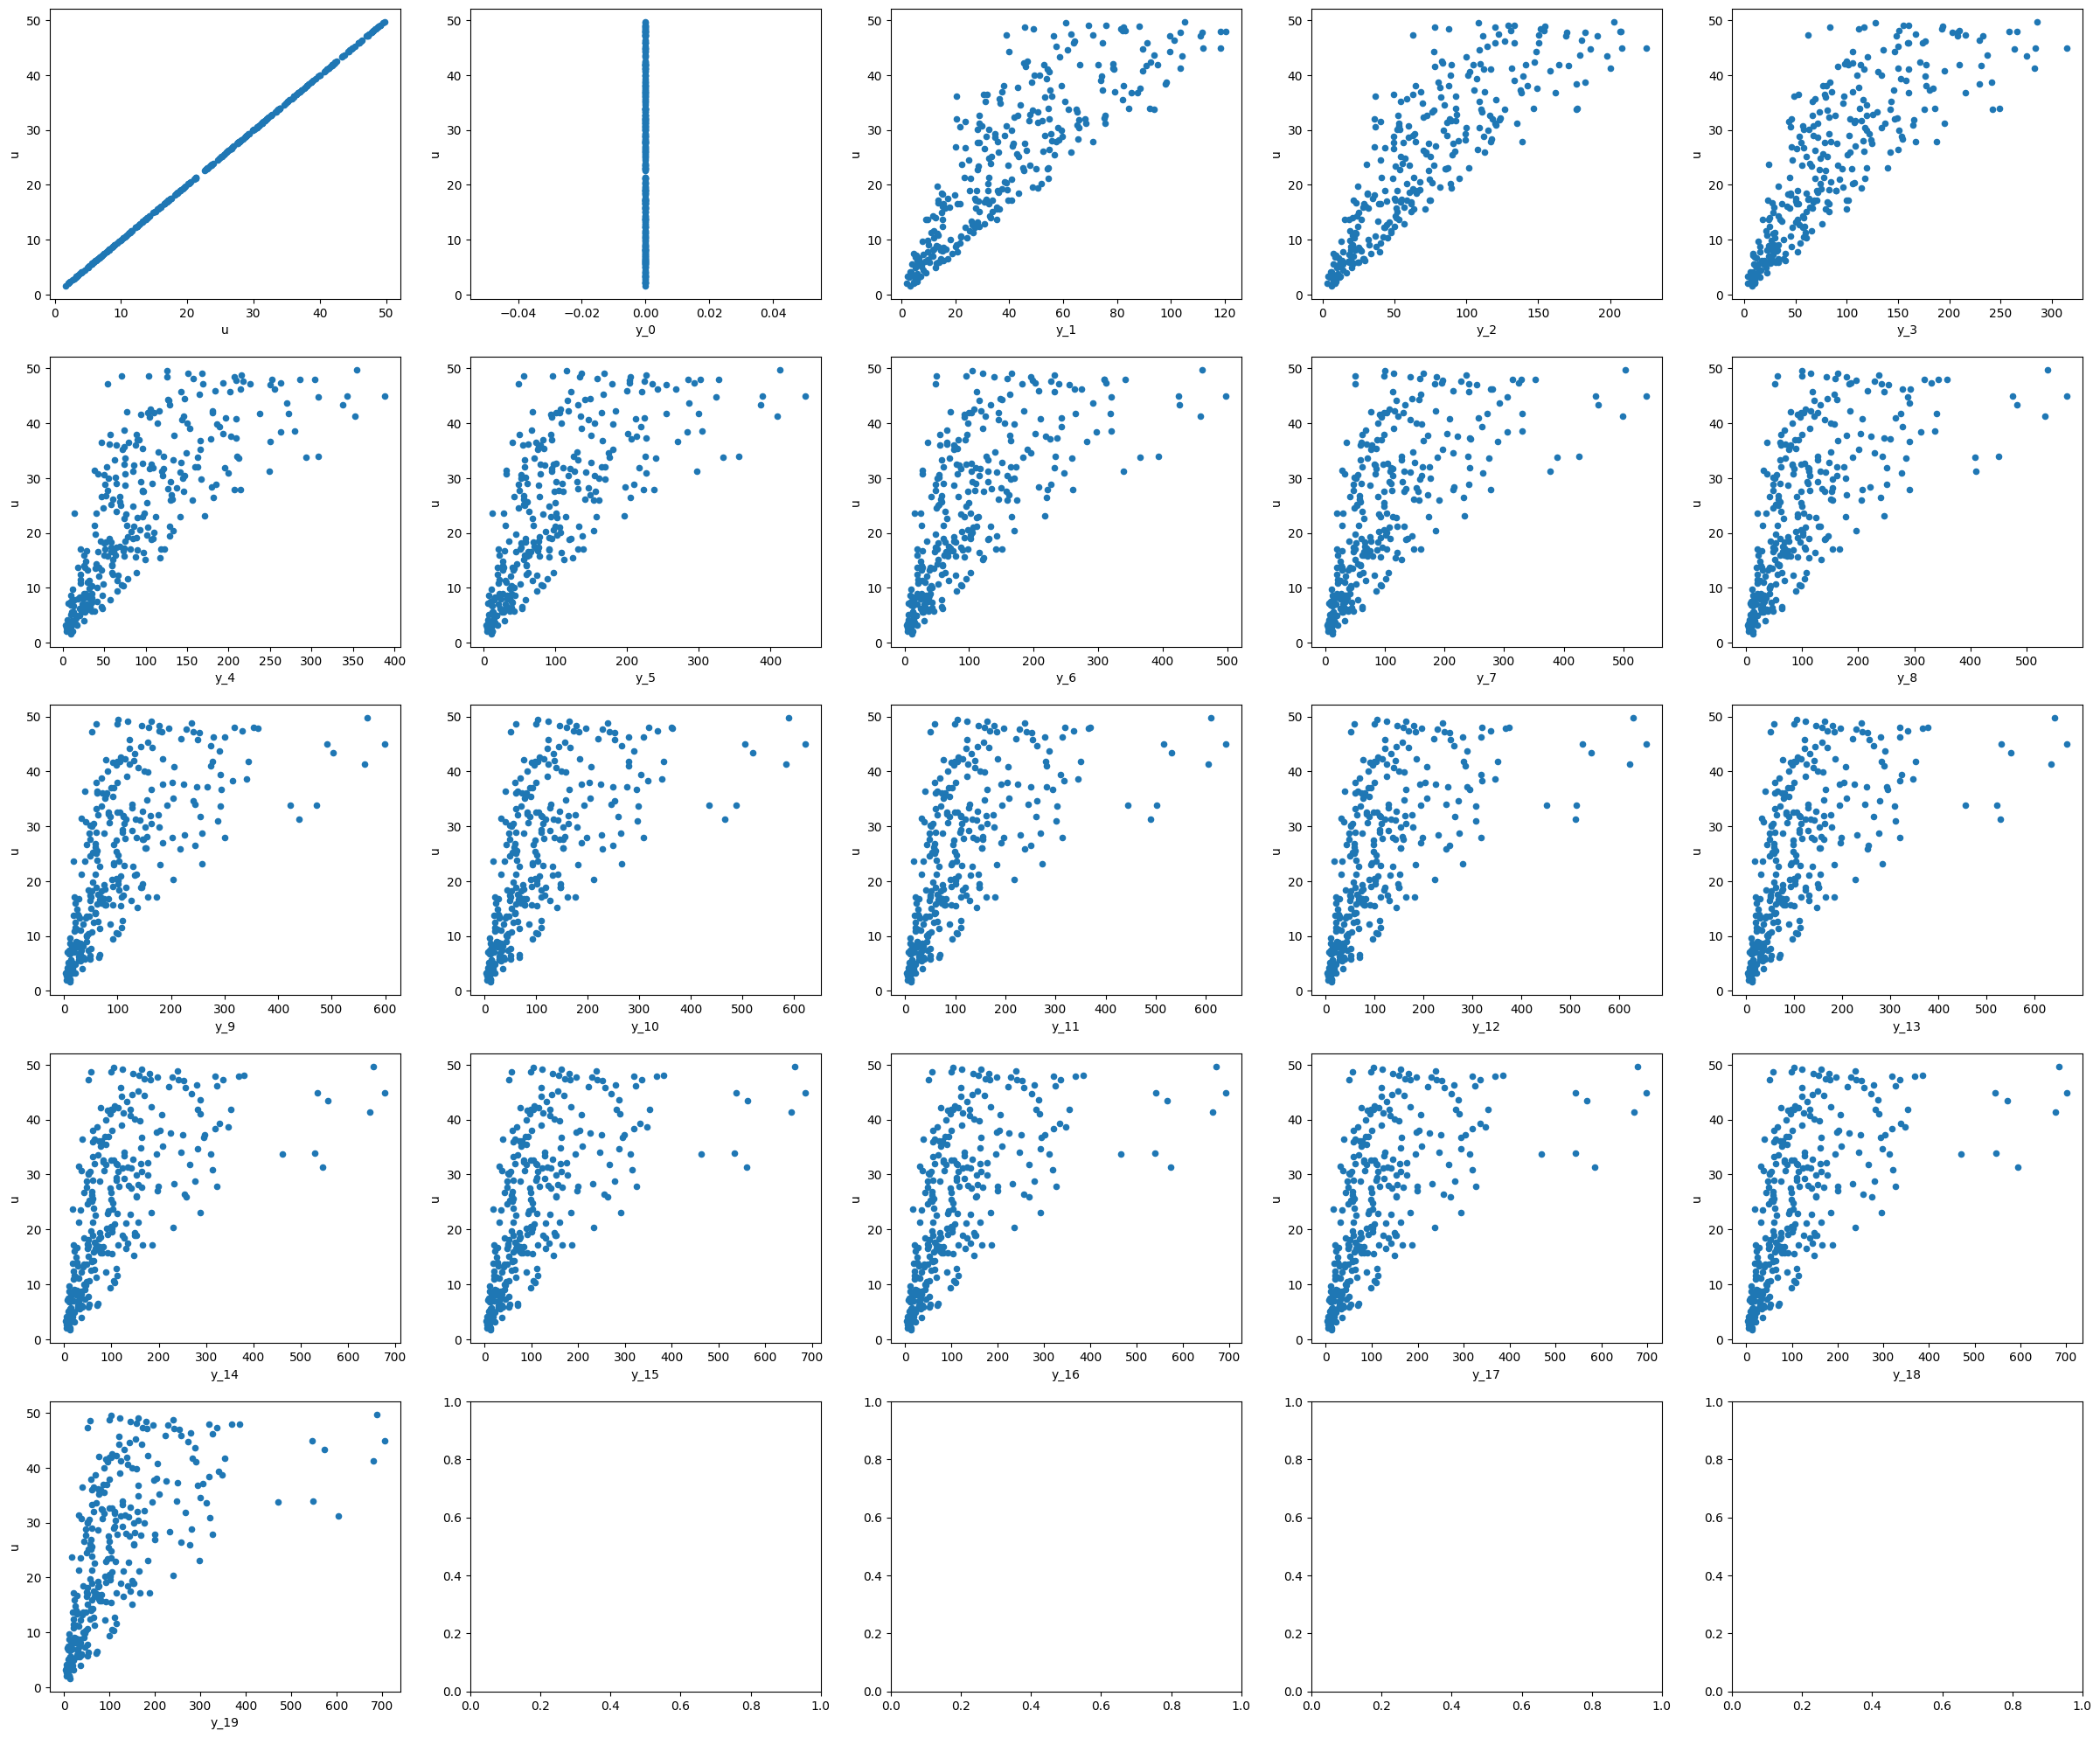

In [65]:
def plot_on_key(in_out, key):
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(30, 25))
    for idx, feature in enumerate(in_out.columns):
        in_out.plot(feature, "u", subplots=True, kind="scatter", ax=axes[idx // 5, idx % 5])
    plt.show()
plot_on_key(in_out, 'u')

Дополнительно рассмотрим зависимость на графиках выше при помощи тепловой карты

<Axes: >

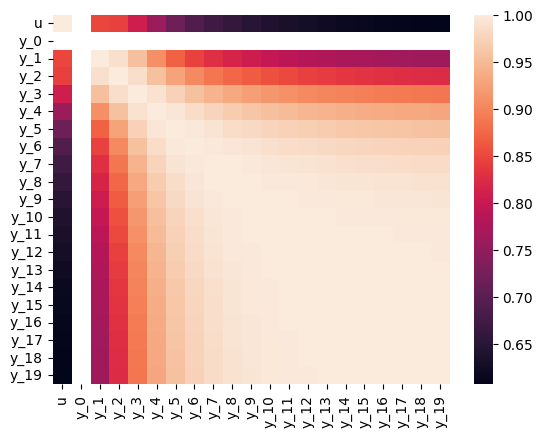

In [66]:
sns.heatmap(in_out.corr())

Можно заметить сходство в корреляции между сигналами, поэтому есть смысл понизить размерность для удобства.

In [156]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(['a1', 'a2', 'b1', 'b2'], axis=1))
# оставили в таблице только y_1-19, u
df_scaled.shape


(300, 22)

In [99]:
model = PCA(n_components=3)
model.fit(df_scaled)
df_pca_3 = model.transform(df_scaled)

In [107]:
df_draw = pd.DataFrame({
    'class': df['u'],
    'pca1': df_pca_3[:, 0],
    'pca2': df_pca_3[:, 1],
    'pca3': df_pca_3[:, 2],
})
colors = ['r', 'g', 'b']

df_draw.shape

(300, 4)

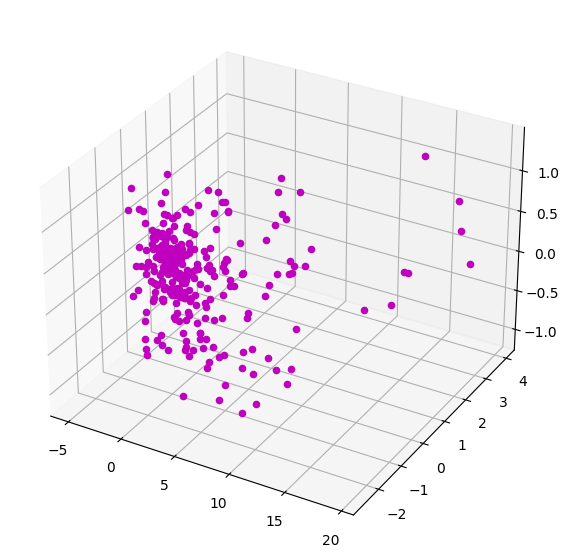

In [165]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

for f in enumerate(df_draw.iterrows()):
        ax.scatter(f[1][1]['pca1'], f[1][1]['pca2'], f[1][1]['pca3'], c='m')

plt.show()

В системе наблюдаются выбросы

Далее проверим, существует ли зависимость между входным сигналом и коэффициентами матриц модели установки.

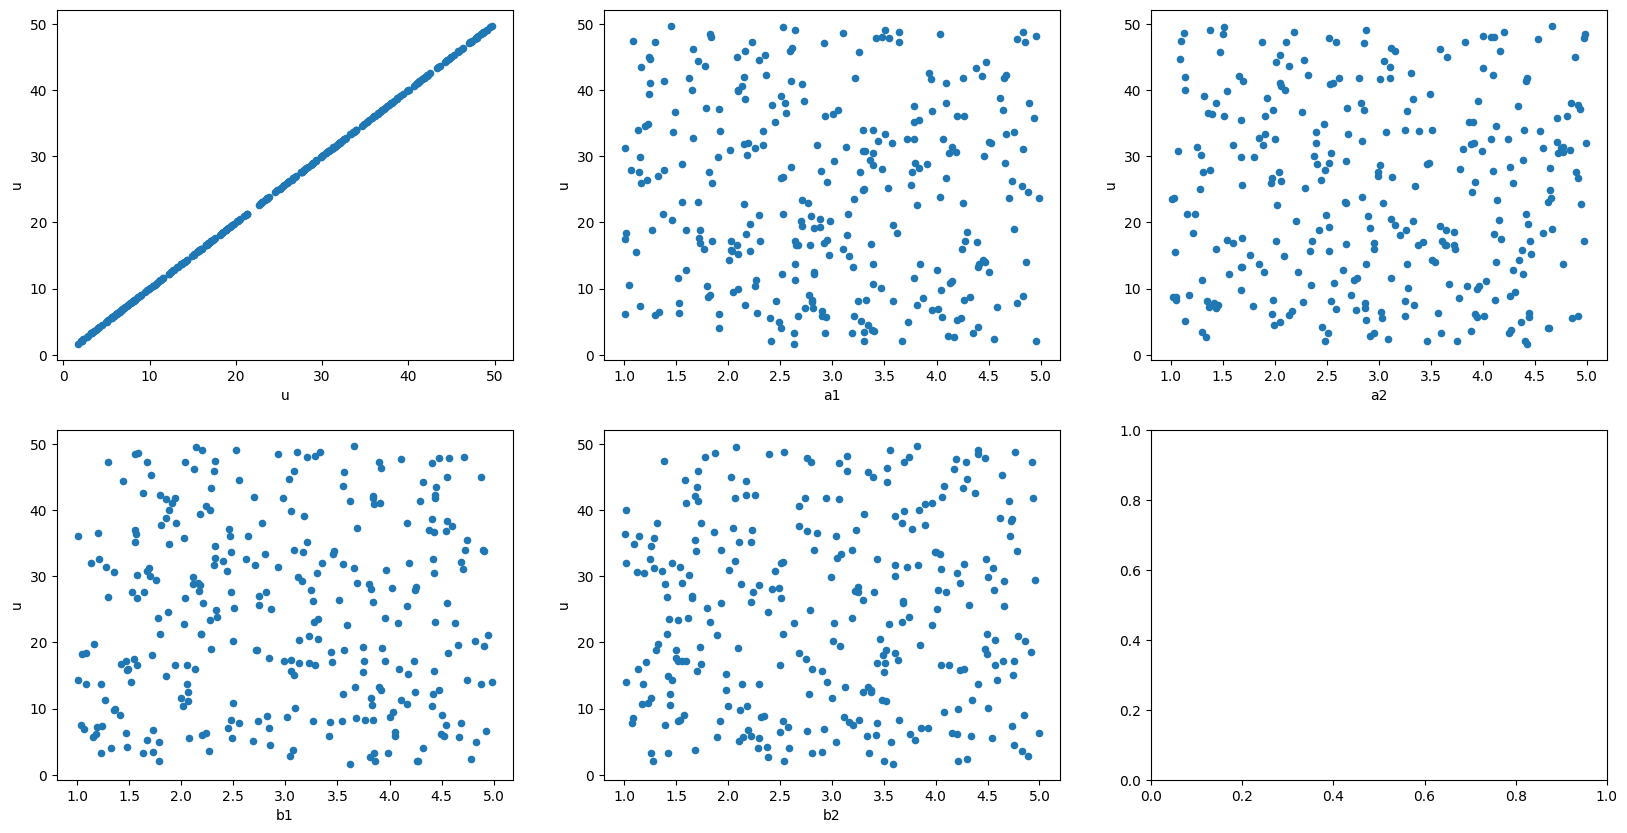

In [166]:
def plot_on_key(input_coeff, key):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
    for idx, feature in enumerate(input_coeff.columns):
        input_coeff.plot(feature, "u", subplots=True, kind="scatter", ax=axes[idx // 3, idx % 3])
    plt.show()
plot_on_key(input_coeff, 'u')

По графикам можно заметить, что корелляция отсутствует

# **Бейзлайн-модель**

Деление выборки по категориям

In [186]:
out_signal = df[['y_1', 'y_16','u']] # Значения выходного сигнала. Для каждого эксперимента снято по 20 точек
out_signal.head()

,y_1,y_16,u
0,103.470474,228.545542,47.730118
1,47.284430,111.580655,31.755654
2,12.003113,46.769713,10.395001
3,5.945856,37.047172,6.134611
4,61.878596,194.679661,33.804580


In [176]:
input_signal = df[['u']] # Значения входного сигнала.
input_signal.head()

,u
0,47.730118
1,31.755654
2,10.395001
3,6.134611
4,33.804580


In [177]:
coefficients = df[['a1', 'a2', 'b1', 'b2']] # Коэффициенты модели
coefficients.head()

,a1,a2,b1,b2
0,4.768043,4.528949,4.114231,4.197650
1,2.332872,1.885917,2.314809,3.828850
2,2.255614,3.962950,2.019615,2.178595
3,1.005294,1.969880,1.180354,3.752236
4,2.334700,3.389631,3.470272,1.687632


In [197]:
scaler = StandardScaler()
X_array = scaler.fit_transform(out_signal)
Y_array = scaler.fit_transform(coefficients) #target

In [192]:
X_array.shape, Y_array.shape

((300, 3), (300, 4))

Проведем разбиение на обучающую (75%) и тестовую (25%) выборки при помощи train_test_split:

In [193]:
X_array_train, X_array_test = train_test_split(X_array, test_size=0.25, random_state=0)
X_array_train.shape, X_array_test.shape

((225, 3), (75, 3))

In [203]:
Y_array_train, Y_array_test = train_test_split(Y_array, test_size=0.25, random_state=0)
Y_array_train.shape, Y_array_test.shape

((225, 4), (75, 4))

**DummyCalssifier - Baseline**

In [210]:
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_array_train, Y_array_train);
y_dummy_predict = dummy_reg.predict(X_array_test)

In [211]:
print("Mean absolute error (dummy-test): {:.7f}".format(mean_absolute_error(Y_array_test, y_dummy_predict)))

Mean absolute error (dummy-test): 0.8605246


### **Линейная регрессия**

**MAE**

Обучим модель и выведем среднюю абсолютную ошибку для тренировочной и тестовой выборок

In [198]:
linear_reg = LinearRegression()

linear_reg.fit(X_array_train, Y_array_train)

Y_train_prediction = linear_reg.predict(X_array_train)
print("Mean absolute error (LinearRegression-train): {:.7f}".format(mean_absolute_error(Y_array_train, Y_train_prediction)))

Y_test_prediction = linear_reg.predict(X_array_test)
print("Mean absolute error (LinearRegression-test): {:.7f}".format(mean_absolute_error(Y_array_test, Y_test_prediction)))

Mean absolute error (LinearRegression-train): 0.6713953
Mean absolute error (LinearRegression-test): 0.6706008


**MSE & RMSE**

Обучим модель и выведем среднюю квадратичную ошибку для тренировочной и тестовой выборок

In [212]:
print(f'MSE for Dummy Regressor: {mean_squared_error(Y_array_test, y_dummy_predict)}')
print(f'MSE for Linear regression: {mean_squared_error(Y_array_test, Y_test_prediction)}')

MSE for Dummy Regressor: 0.996249733898944
MSE for Linear regression: 0.6865692288374456


In [215]:
print(f'RMSE for Dummy Regressor: {mean_squared_error(Y_array_test, y_dummy_predict, squared=False)}')
print(f'RMSE for Linear regression: {mean_squared_error(Y_array_test, Y_test_prediction, squared=False)}')

RMSE for Dummy Regressor: 0.9970829696729658
RMSE for Linear regression: 0.8035492997822302


In [237]:
def plot_model_results(actual, predicted, title):
  results = pd.DataFrame({'True': actual, 'Prediction': predicted})
  sns.lmplot(x='True', y='Prediction', data=results, fit_reg=False)
  d_line= np.arange(results.min().min(), results.max().max())
  plt.plot(d_line, d_line, color='red', linestyle='--')
  plt.title = title
  plt.grid()
  plt.show()

In [238]:
Y_array_test.shape, y_dummy_predict.shape, Y_test_prediction.shape

((75, 4), (75, 4), (75, 4))

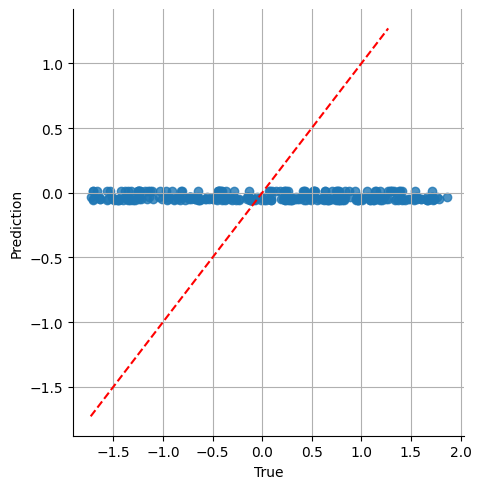

In [240]:
plot_model_results(Y_array_test.flatten(), y_dummy_predict.flatten(), title='Dummy')

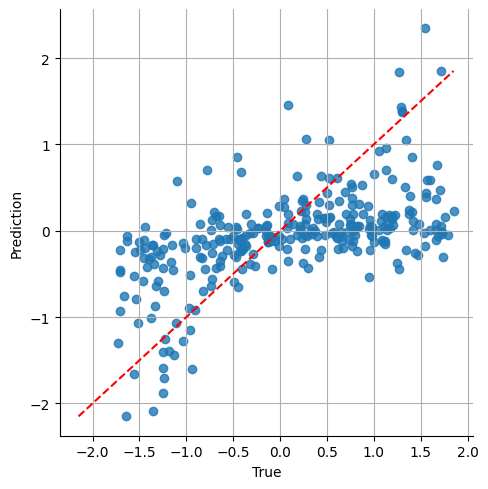

In [241]:
plot_model_results(Y_array_test.flatten(), Y_test_prediction.flatten(), title='Linear Regression')

В качестве бейзлайн-модели было решено использовать Линейную регрессию, тк посчитанные выше ошибки меньше, а также из-за получившегося графика.